In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ventilator-pressure-prediction/sample_submission.csv
/kaggle/input/ventilator-pressure-prediction/train.csv
/kaggle/input/ventilator-pressure-prediction/test.csv


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import os
import sklearn
import warnings
import seaborn as sns

from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import BatchNormalization
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

2024-06-03 07:19:54.354028: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 07:19:54.354168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 07:19:54.521057: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_path = '/kaggle/input/ventilator-pressure-prediction/'

dataset_train = data_path + 'train.csv';
dataset_test = data_path + 'test.csv';
dataset_submission = data_path + 'sample_submission.csv';

In [4]:
train = pd.read_csv(dataset_train)
test = pd.read_csv(dataset_test)
submission = pd.read_csv(dataset_submission)

In [5]:
train.head()
train

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938


In [6]:
test.head()
test

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0
...,...,...,...,...,...,...,...
4023995,4023996,125748,20,10,2.530117,4.971245,1
4023996,4023997,125748,20,10,2.563853,4.975709,1
4023997,4023998,125748,20,10,2.597475,4.979468,1
4023998,4023999,125748,20,10,2.631134,4.982648,1


In [7]:
train.info()
train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938


In [8]:
test.info()
test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024000 entries, 0 to 4023999
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
dtypes: float64(2), int64(5)
memory usage: 214.9 MB


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0
...,...,...,...,...,...,...,...
4023995,4023996,125748,20,10,2.530117,4.971245,1
4023996,4023997,125748,20,10,2.563853,4.975709,1
4023997,4023998,125748,20,10,2.597475,4.979468,1
4023998,4023999,125748,20,10,2.631134,4.982648,1


In [9]:
 np.unique(train['R'])

array([ 5, 20, 50])

In [10]:
train.head(n = 400)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
395,396,5,5,50,2.587415,4.980725,1,5.837492
396,397,5,5,50,2.621570,4.983751,1,5.837492
397,398,5,5,50,2.656784,4.986374,1,5.837492
398,399,5,5,50,2.690775,4.988504,1,6.048398


In [11]:
np.unique(train['breath_id'], return_counts = True)

(array([     1,      2,      3, ..., 125743, 125745, 125749]),
 array([80, 80, 80, ..., 80, 80, 80]))

In [12]:
final = train.groupby(['breath_id'])
final.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
6035920,6035921,125749,50,10,0.000000,6.030572,0,3.939334
6035921,6035922,125749,50,10,0.033187,25.504196,0,5.345377
6035922,6035923,125749,50,10,0.066365,21.614707,0,9.563505
6035923,6035924,125749,50,10,0.099784,16.266744,0,15.117375


In [13]:
data = train.groupby(['breath_id'])
data.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
6035920,6035921,125749,50,10,0.000000,6.030572,0,3.939334
6035921,6035922,125749,50,10,0.033187,25.504196,0,5.345377
6035922,6035923,125749,50,10,0.066365,21.614707,0,9.563505
6035923,6035924,125749,50,10,0.099784,16.266744,0,15.117375


In [14]:
train['un_in_std'] = data['u_in'].transform(lambda x : (x - x.mean() / x.std()))
train['time_step_std'] = data['time_step'].transform(lambda x : (x - x.mean() / x.std()))

In [15]:
train['time_step_after'] = data[['time_step_std']].shift()
train['un_in_after '] = data[['un_in_std']].shift()
train['u_out_after'] = data[['u_out']].shift()
train['time_step_back'] = data[['time_step_std']].shift(-1)
train['un_in_back'] = data[['un_in_std']].shift(-1)
train['u_out_back'] = data[['u_out']].shift(-1)
train['time_step_after2'] = data[['time_step_std']].shift(2)
train['un_in_after2'] = data[['un_in_std']].shift(2)
train['u_out_after2'] = data[['u_out']].shift(2)
train['time_step_back2'] = data[['time_step_std']].shift(-2)
train['un_in_back2'] = data[['un_in_std']].shift(-2)
train['u_out_back2'] = data[['u_out']].shift(-2)
train['time_step_after3'] = data[['time_step_std']].shift(3)
train['un_in_after3'] = data[['un_in_std']].shift(3)
train['u_out_after3'] = data[['u_out']].shift(3)
train['time_step_back3'] = data[['time_step_std']].shift(-3)
train['un_in_back3'] = data[['un_in_std']].shift(-3)
train['u_out_back3'] = data[['u_out']].shift(-3)
train['time_step_after4'] = data[['time_step_std']].shift(4)
train['un_in_after4'] = data[['un_in_std']].shift(4)
train['u_out_after4'] = data[['u_out']].shift(4)
train['time_step_back4'] = data[['time_step_std']].shift(-4)
train['un_in_back4'] = data[['un_in_std']].shift(-4)
train['u_out_back4'] = data[['u_out']].shift(-4)
train['time_step_after5'] = data[['time_step_std']].shift(5)
train['un_in_after5'] = data[['un_in_std']].shift(5)
train['u_out_after5'] = data[['u_out']].shift(5)
train['time_step_back5'] = data[['time_step_std']].shift(-5)
train['un_in_back5'] = data[['un_in_std']].shift(-5)
train['u_out_back5'] = data[['u_out']].shift(-5)

In [16]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,un_in_std,time_step_std,...,u_out_after4,time_step_back4,un_in_back4,u_out_back4,time_step_after5,un_in_after5,u_out_after5,time_step_back5,un_in_back5,u_out_back5
0,1,1,20,50,0.000000,0.083334,0,5.837492,-0.918872,-1.699182,...,NaN,-1.563426,24.353644,0.0,NaN,NaN,NaN,-1.529484,26.257659,0.0
1,2,1,20,50,0.033652,18.383041,0,5.907794,17.380835,-1.665530,...,NaN,-1.529484,26.257659,0.0,NaN,NaN,NaN,-1.495474,26.125279,0.0
2,3,1,20,50,0.067514,22.509278,0,7.876254,21.507071,-1.631667,...,NaN,-1.495474,26.125279,0.0,NaN,NaN,NaN,-1.461459,25.805525,0.0
3,4,1,20,50,0.101542,22.808822,0,11.742872,21.806616,-1.597640,...,NaN,-1.461459,25.805525,0.0,NaN,NaN,NaN,-1.427405,26.862509,0.0
4,5,1,20,50,0.135756,25.355850,0,12.234987,24.353644,-1.563426,...,0.0,-1.427405,26.862509,0.0,NaN,NaN,NaN,-1.393450,27.310829,0.0


In [17]:
train.fillna(0, inplace = True)

In [18]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,un_in_std,time_step_std,...,u_out_after4,time_step_back4,un_in_back4,u_out_back4,time_step_after5,un_in_after5,u_out_after5,time_step_back5,un_in_back5,u_out_back5
0,1,1,20,50,0.000000,0.083334,0,5.837492,-0.918872,-1.699182,...,0.0,-1.563426,24.353644,0.0,0.0,0.0,0.0,-1.529484,26.257659,0.0
1,2,1,20,50,0.033652,18.383041,0,5.907794,17.380835,-1.665530,...,0.0,-1.529484,26.257659,0.0,0.0,0.0,0.0,-1.495474,26.125279,0.0
2,3,1,20,50,0.067514,22.509278,0,7.876254,21.507071,-1.631667,...,0.0,-1.495474,26.125279,0.0,0.0,0.0,0.0,-1.461459,25.805525,0.0
3,4,1,20,50,0.101542,22.808822,0,11.742872,21.806616,-1.597640,...,0.0,-1.461459,25.805525,0.0,0.0,0.0,0.0,-1.427405,26.862509,0.0
4,5,1,20,50,0.135756,25.355850,0,12.234987,24.353644,-1.563426,...,0.0,-1.427405,26.862509,0.0,0.0,0.0,0.0,-1.393450,27.310829,0.0


In [19]:
features = train.drop(['pressure', 'id', 'breath_id', 'time_step', 'u_in'], axis = 1)
target = train['pressure']

In [20]:
features.head()

,R,C,u_out,un_in_std,time_step_std,time_step_after,un_in_after,u_out_after,time_step_back,un_in_back,...,u_out_after4,time_step_back4,un_in_back4,u_out_back4,time_step_after5,un_in_after5,u_out_after5,time_step_back5,un_in_back5,u_out_back5
0,20,50,0,-0.918872,-1.699182,0.000000,0.000000,0.0,-1.665530,17.380835,...,0.0,-1.563426,24.353644,0.0,0.0,0.0,0.0,-1.529484,26.257659,0.0
1,20,50,0,17.380835,-1.665530,-1.699182,-0.918872,0.0,-1.631667,21.507071,...,0.0,-1.529484,26.257659,0.0,0.0,0.0,0.0,-1.495474,26.125279,0.0
2,20,50,0,21.507071,-1.631667,-1.665530,17.380835,0.0,-1.597640,21.806616,...,0.0,-1.495474,26.125279,0.0,0.0,0.0,0.0,-1.461459,25.805525,0.0
3,20,50,0,21.806616,-1.597640,-1.631667,21.507071,0.0,-1.563426,24.353644,...,0.0,-1.461459,25.805525,0.0,0.0,0.0,0.0,-1.427405,26.862509,0.0
4,20,50,0,24.353644,-1.563426,-1.597640,21.806616,0.0,-1.529484,26.257659,...,0.0,-1.427405,26.862509,0.0,0.0,0.0,0.0,-1.393450,27.310829,0.0


In [21]:
features = np.array(features)
features.shape

(6036000, 35)

In [22]:
features = features.reshape(int(features.shape[0]/80), 80, features.shape[1])
features.shape

(75450, 80, 35)

In [23]:
target = np.array(target)
target.shape

(6036000,)

In [24]:
target = target.reshape(75450, 80)
target.shape

(75450, 80)

In [25]:
norm = tf.keras.layers.Normalization(input_shape = [80, features.shape[2],],axis = -1)
norm.adapt(features)

Deep learning Model

In [26]:
model = Sequential()

In [27]:
max_pooling_layer = MaxPooling1D(pool_size = 2)
model.add(max_pooling_layer)

In [28]:
model = tf.keras.Sequential([
        norm,
        tf.keras.layers.Conv1D(125, 3, activation = 'relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(256, 8, activation = 'relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True)),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(80, )
])
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss= 'mae')

In [29]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 80, 35)         │            71 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 78, 125)        │        13,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 39, 125)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 39, 125)        │           500 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 256)        │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 16, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 16, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 16, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │        20,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,080,141 (4.12 MB)

 Trainable params: 1,079,308 (4.12 MB)

 Non-trainable params: 833 (3.26 KB)

Training Model

In [30]:
history = model.fit(features, target, validation_split = 0.2, epochs = 15, batch_size = 512,
                    callbacks = [tf.keras.callbacks.EarlyStopping(patience = 300,
                                                                  monitor= 'val_loss',
                                                                  mode = 'min',
                                                                  restore_best_weights = True)])

Epoch 1/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 122s 966ms/step - loss: 6.6048 - val_loss: 2.8240
Epoch 2/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 111s 938ms/step - loss: 2.5559 - val_loss: 1.7613
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 113s 956ms/step - loss: 1.8602 - val_loss: 1.5430
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 142s 954ms/step - loss: 1.6276 - val_loss: 1.2441
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 113s 955ms/step - loss: 1.5020 - val_loss: 1.2321
Epoch 6/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 111s 942ms/step - loss: 1.4124 - val_loss: 1.0971
Epoch 7/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 142s 941ms/step - loss: 1.3678 - val_loss: 1.0506
Epoch 8/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 143s 947ms/step - loss: 1.3358 - val_loss: 0.9845
Epoch 9/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 114s 964ms/step - loss: 1.2798 - val_loss: 0.9156
Epoch 10/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 141s 952ms/step - loss: 1.2597 - val_loss: 0.8939
Epoch 11/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 143s 962ms/step - loss: 1.2299 - val_loss: 0.8633
Epoch 12

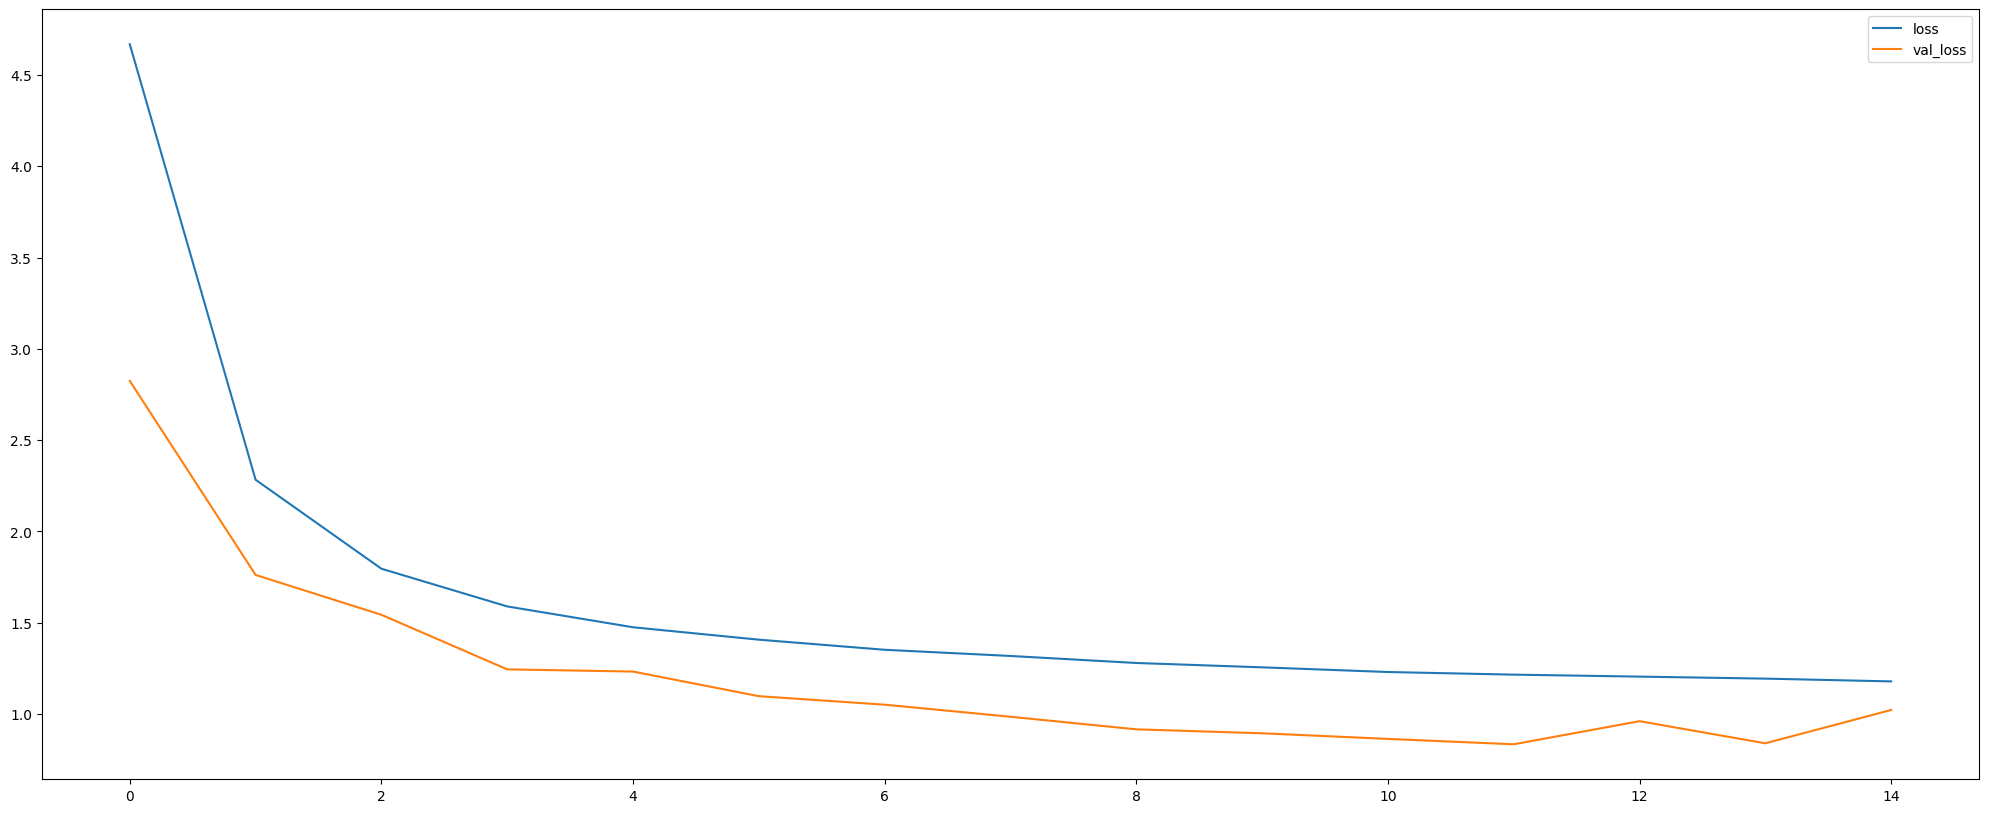

In [31]:
plt.figure(figsize = (25, 10))
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()

In [32]:
model.evaluate(features, target)

2358/2358 ━━━━━━━━━━━━━━━━━━━━ 72s 30ms/step - loss: 0.8294


0.8294960260391235

In [33]:
y_pred = model.predict(features, batch_size = 512)

148/148 ━━━━━━━━━━━━━━━━━━━━ 37s 245ms/step


In [34]:
target[0], y_pred[0]

(array([ 5.83749171,  5.90779385,  7.87625392, 11.74287192, 12.23498694,
        12.86770625, 14.69556203, 15.8906985 , 15.53918778, 15.75009421,
        17.29674141, 17.22643927, 16.17190709, 17.36704356, 18.07006501,
        17.15613712, 18.28097145, 18.77308647, 17.85915858, 19.1245972 ,
        19.33550363, 18.49187789, 18.56218003, 18.63248218, 18.84338861,
        19.05429505, 19.26520149, 19.33550363, 19.33550363, 19.47610792,
        19.54641007, 17.01553283,  9.56350541,  7.87625392,  8.64957752,
         7.59504534,  7.66534749,  8.2980668 ,  7.24353461,  7.94655607,
         7.59504534,  7.45444105,  8.1574625 ,  6.82172174,  7.17323247,
         7.5247432 ,  6.96232603,  7.45444105,  7.59504534,  7.17323247,
         7.73564963,  7.24353461,  7.59504534,  7.3841389 ,  7.24353461,
         7.73564963,  7.5247432 ,  6.96232603,  7.10293032,  7.31383676,
         6.11870029,  7.03262818,  6.82172174,  6.54051316,  6.96232603,
         6.82172174,  6.54051316,  6.82172174,  6.8

In [35]:
y_pred[0]

array([ 6.1645937,  6.5392632,  8.786549 , 11.623077 , 12.107744 ,
       12.488052 , 13.819769 , 14.90486  , 15.453429 , 15.827854 ,
       16.391874 , 16.763664 , 17.193613 , 17.530155 , 17.734985 ,
       18.001375 , 18.272497 , 18.399529 , 18.694944 , 18.837173 ,
       19.078203 , 19.236282 , 19.390394 , 19.567225 , 19.867157 ,
       19.909306 , 19.972431 , 20.240057 , 20.405495 , 20.504782 ,
       19.249485 , 13.357595 , 10.874483 ,  9.431271 ,  8.243017 ,
        7.8224425,  7.701412 ,  7.6435943,  7.4722548,  7.409966 ,
        7.22583  ,  7.182019 ,  7.0708365,  6.9811144,  6.9345455,
        6.958971 ,  6.8963685,  6.9606814,  7.0128837,  7.0159717,
        7.11936  ,  7.17327  ,  7.0194793,  6.915195 ,  7.1418886,
        7.0523767,  7.046943 ,  6.866121 ,  7.0599437,  6.670014 ,
        6.7611713,  6.705471 ,  6.6866555,  6.6302137,  6.4859543,
        6.562824 ,  6.525199 ,  6.4629407,  6.4499717,  6.406471 ,
        6.419487 ,  6.389861 ,  6.370448 ,  6.3476467,  6.3489

In [36]:
def draw_result(start, end, target, y_pred) :
    plt.figure(figsize = (20, 7))
    plt.plot(np.reshape(target[start : end], -1), linewidth = 5, label = 'actual Prossure values')
    plt.plot(np.reshape(y_pred[start : end], -1), linewidth = 5, label = 'predict Prossure values')
    plt.legend()

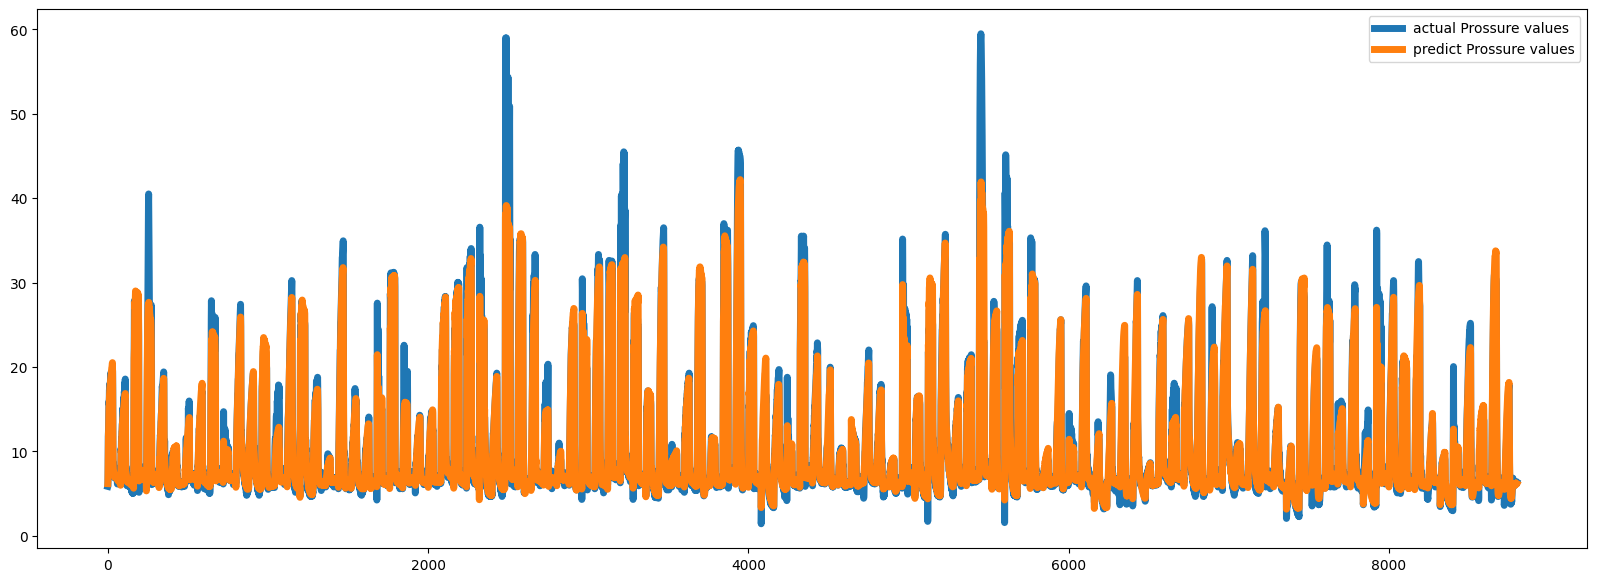

In [37]:
draw_result(0, 110, target, y_pred)

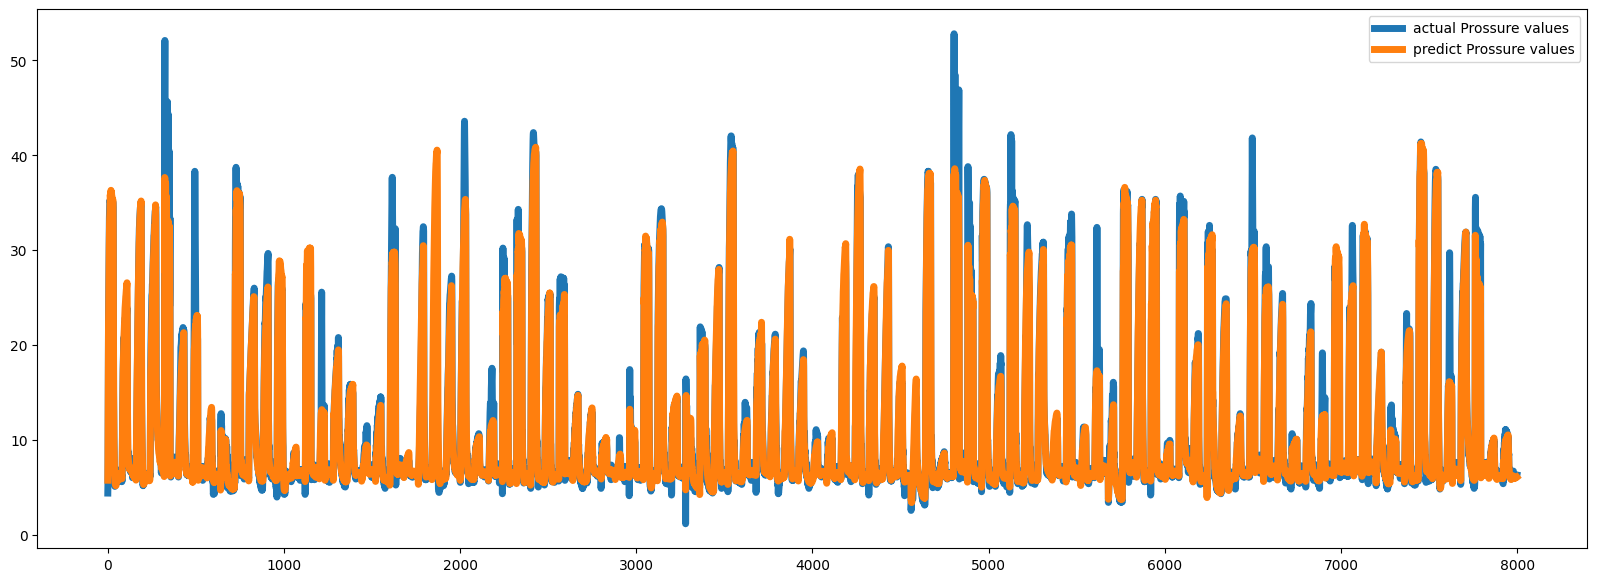

In [38]:
draw_result(110, 210, target, y_pred)

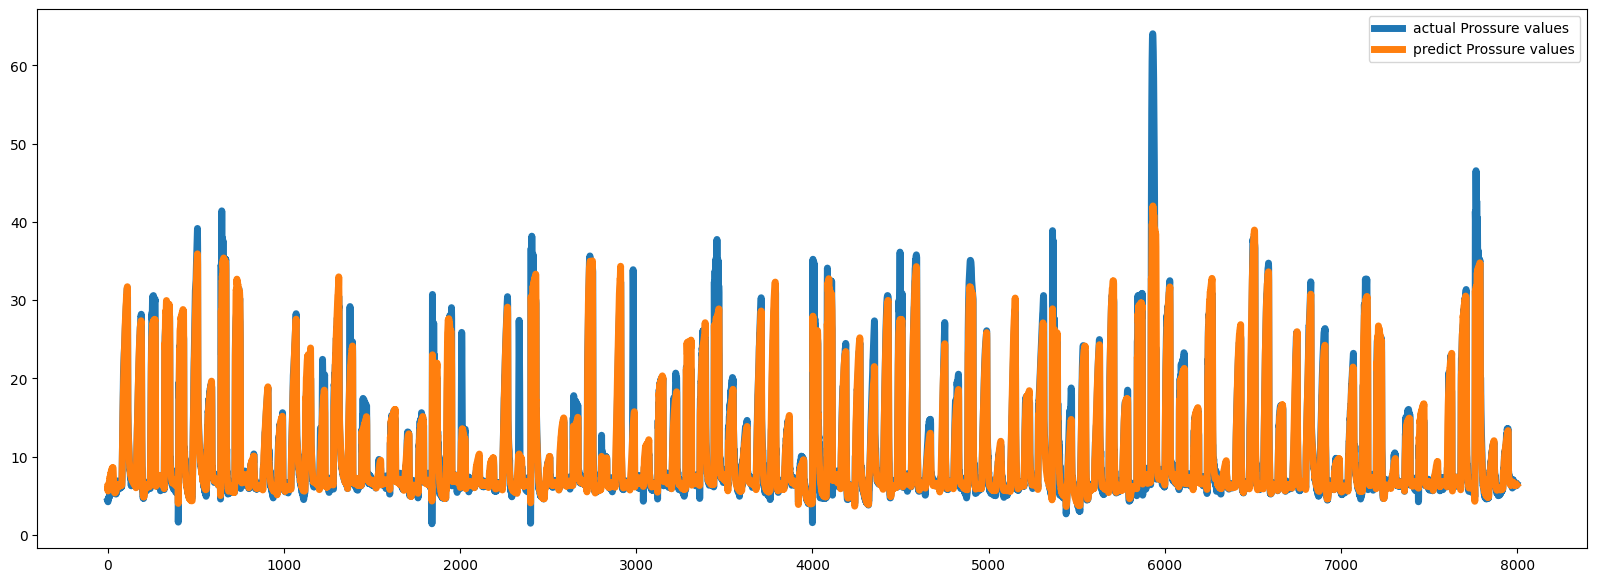

In [39]:
draw_result(210, 310, target, y_pred)

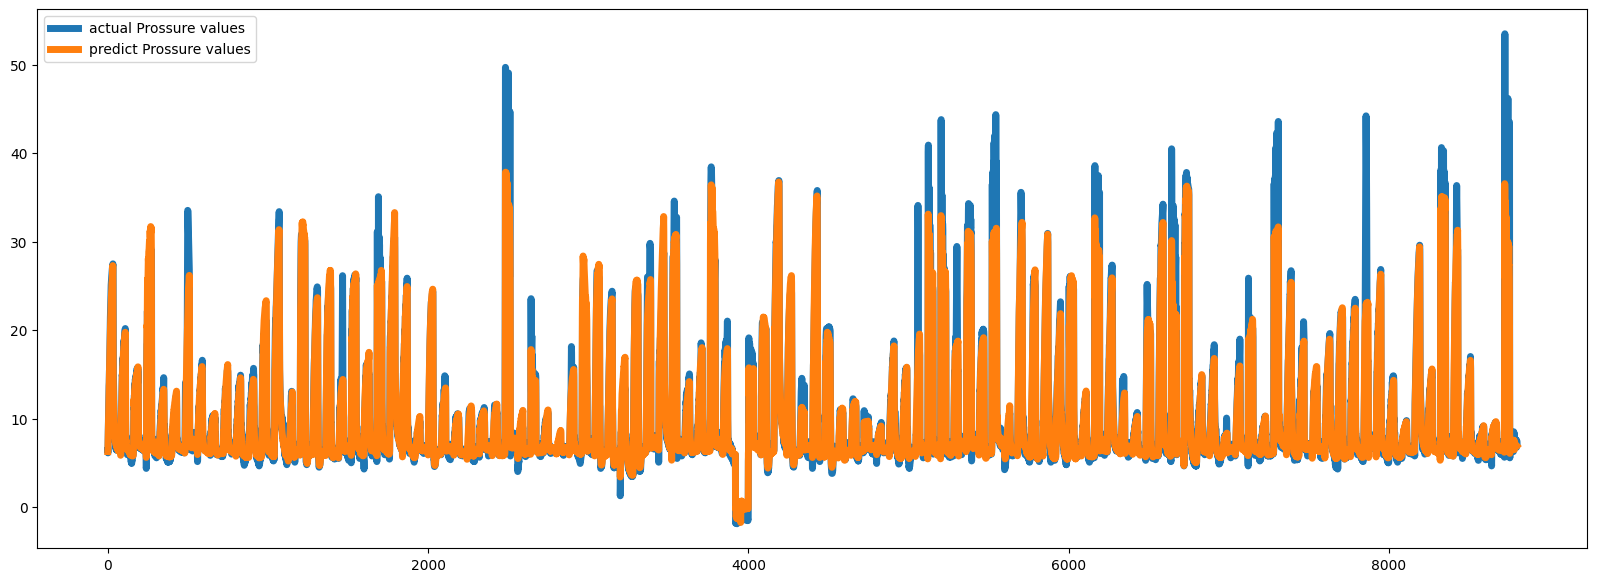

In [40]:
draw_result(310, 420, target, y_pred)

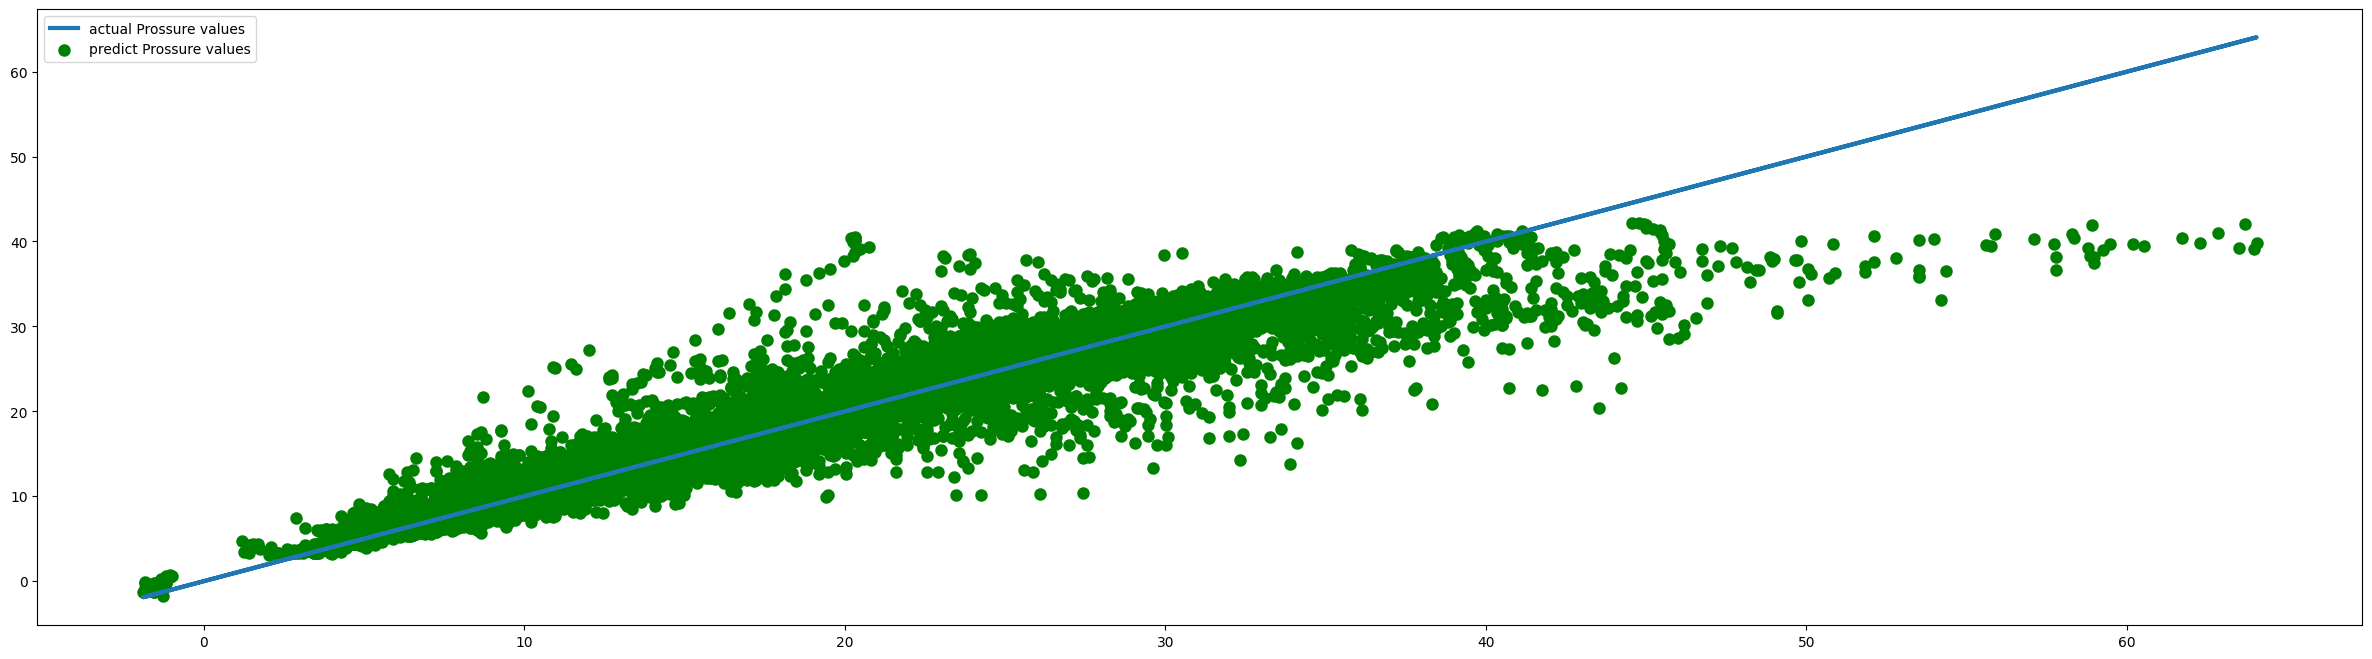

In [41]:
plt.figure(figsize = (30, 8))
plt.plot(np.reshape(target[:500], -1), np.reshape(target[:500] , -1), linewidth = 3, label = "actual Prossure values")
plt.scatter(np.reshape(target[:500], -1), np.reshape(y_pred[:500], -1), c = 'g', linewidth = 3, label = "predict Prossure values")
plt.legend()

In [42]:
def create_table(target, y_pred) :
    target = np.reshape(target, -1)
    y_pred = np.reshape(y_pred, -1)
    
    return pd.DataFrame({
        "actual Prossure values" : target,
        "predict Prossure values" : y_pred,
        "diff" : np.abs(target, y_pred)
    })

In [43]:
create_table(target, y_pred).head(n = 40)

,actual Prossure values,predict Prossure values,diff
0,5.837492,5.837492,5.837492
1,5.907794,5.907794,5.907794
2,7.876254,7.876254,7.876254
3,11.742872,11.742872,11.742872
4,12.234987,12.234987,12.234987
5,12.867706,12.867706,12.867706
6,14.695562,14.695562,14.695562
7,15.890699,15.890698,15.890698
8,15.539188,15.539187,15.539187
9,15.750094,15.750094,15.750094


In [44]:
submission = create_table